In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as ss


## Fourier transform and sliding fourier transform of an arbitrary signal


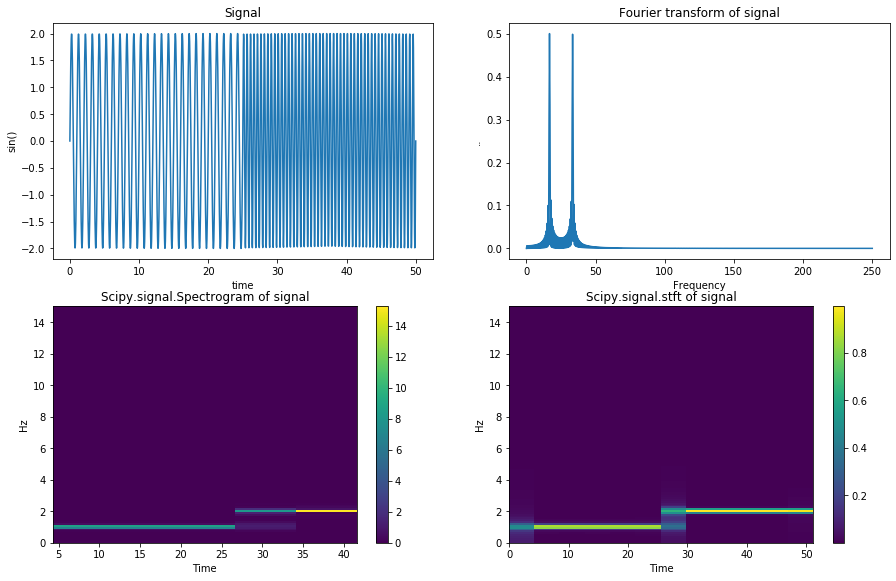

In [2]:

sss = 0 # start of interval
se = 50 # end of interval
amp = 2 * 0.5 # 1
fs = 30 # Sampling frequency (sampled points per time unit)
N = fs * se # number of sampled points
time = np.linspace(0,se,N)  # time points
freq = 2
y= 2*np.sin(np.pi*2*freq*time)*(time>se//2)+2*np.sin(np.pi*freq*time)*(time<se//2)
ftime = np.linspace(0,se*fs/2,N//2)/3 # frequencies
fy = np.fft.fft(y)[:len(y)//2]/len(y) # fourier transform of y
f, t, Z = ss.spectrogram(y, fs) # sliding window of y
ff,tt,ZZ = ss.stft(y,fs)




plt.figure(figsize=(15,20))
plt.subplot(4,2,1)
plt.plot(time,y)
plt.xlabel("time")
plt.ylabel("sin()")
plt.title("Signal")
plt.subplot(4,2,2)
plt.xlabel("Frequency")
plt.ylabel("..")
plt.plot(ftime,np.abs(fy))
plt.title("Fourier transform of signal")

plt.subplot(4,2,3)
plt.pcolormesh(t,f,Z)
plt.colorbar()
plt.ylabel('Hz')
plt.xlabel('Time')
plt.title("Scipy.signal.Spectrogram of signal")
plt.subplot(4,2,4)
plt.pcolormesh(tt,ff,np.abs(ZZ))
plt.colorbar()
plt.ylabel('Hz')
plt.xlabel('Time')
plt.title("Scipy.signal.stft of signal")

plt.show()



In the above figure we observe 4 plots; first the signal in the time interval 0 to 3s, that is a sine wave of frequency 250 Hz uptil 1.5s and  then 500 Hz from 1.5s to the end, the second plot shows the fourier transform of the signal and we clearly see the two distinct frequencies situated at 250 Hz and 500 Hz.

In the lower left corner, the scipy.signal.spectrogram is applied on the signal and we now observe that from 0 to 1.5s the signal has a stationnary frequency of 250 Hz, and then from 1.5s it becomes 500 Hz. 

## Signal with frequency evolving over time


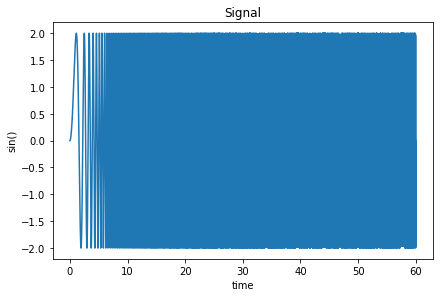

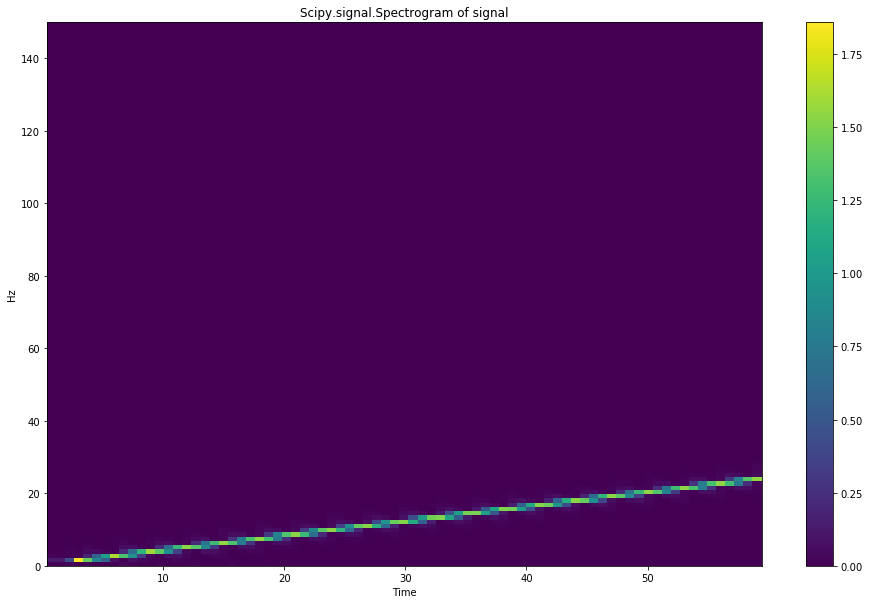

In [3]:
sss = 0 # start of interval
se = 60 # end of interval
amp = 2 * 0.5 # 1
fs = 300 # Sampling frequency (sampled points per time unit)
N = fs * se # number of sampled points
time = np.linspace(0,se,N)  # time points


alpha = 0.2
w = 2*np.pi * time * alpha
y= 2*np.sin(w*time)

f, t, Z = ss.spectrogram(y, fs, nperseg = 256) # sliding window of y
ff,tt,ZZ = ss.stft(y,fs)

plt.figure(figsize=(15,20))
plt.subplot(4,2,1)
plt.plot(time,y)
plt.xlabel("time")
plt.ylabel("sin()")
plt.title("Signal")
plt.show()

plt.figure(figsize=(16,10))

plt.pcolormesh(t,f,Z)
plt.colorbar()
plt.ylabel('Hz')
plt.xlabel('Time')
plt.title("Scipy.signal.Spectrogram of signal")

plt.show()

## Application on the Paracou data

In [4]:
Tifpath = 'StageGMM4_2020_SA4CD/Data/Paracou_125MHz/geo5Md3iHV_t4-7_NCI7_lkLcl3-5-t7_lkRgn9-15.tif'


from osgeo import gdal
from scipy import fftpack
import numpy.linalg as npl

gdal.UseExceptions()
ds = gdal.Open(Tifpath)
ds_band1 = np.array(ds.GetRasterBand(1).ReadAsArray())
ds_band3 = np.array(ds.GetRasterBand(3).ReadAsArray())

ds_target1 = np.zeros(len(ds_band1[1000,:]))
ds_target3 = np.zeros(len(ds_band3[1000,:]))

Ny,Nx = np.shape(ds_band3)
x = np.linspace(0,Nx*5,Nx)
y = np.linspace(0,Ny*5,Ny)


### Test on a specific interval

Here we test wether or not the spectrogram function will be able to detect differences between the two images

In [5]:

ls = 712
le = 728
for i in range(ls,le):
    ds_target1 = ds_band1[i,:] + ds_target1
    ds_target3 = ds_band3[i,:] + ds_target3
ds_target1 = ds_target1/(le-ls)
ds_target3 = ds_target3/(le-ls)
N = len(ds_target1)
length = N*5 # 1 pixel correspond to 5 metres (?)
fs = N/length

x = np.linspace(0,length,N)
xf = np.linspace(0,length*fs/2,N//2)/length
fy = fftpack.fft(ds_target1)[:N//2]/N
fy2 = fftpack.fft(ds_target3)[:N//2]/N

print(np.shape(ds_target3))


(1193,)


<ipython-input-50-ee0efe3133b7>:17: RuntimeWarning: divide by zero encountered in log
  plt.plot(x,np.log(ds_target1)*10,label="band 1")
<ipython-input-50-ee0efe3133b7>:18: RuntimeWarning: divide by zero encountered in log
  plt.plot(x,np.log(ds_target3)*10, label = "band 3")


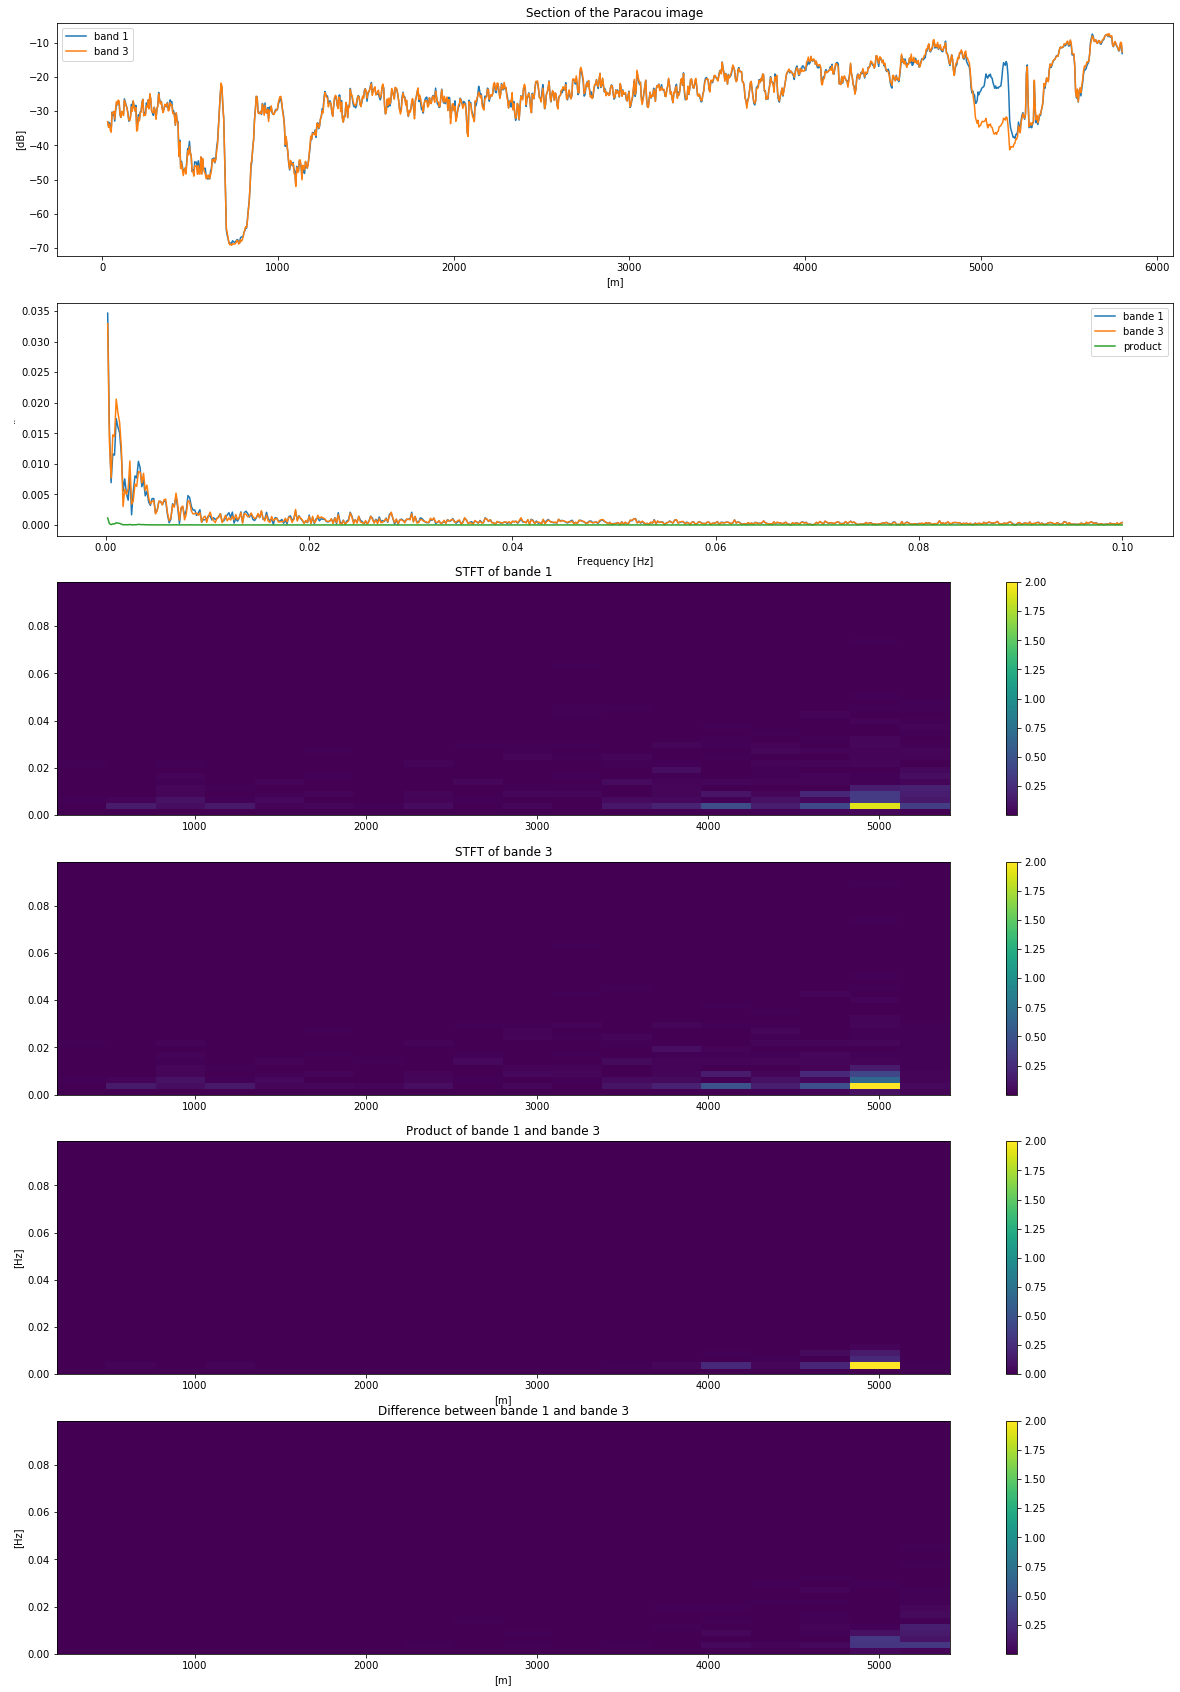

In [50]:

nt = 6

j = ds_target1*ds_target3
nf = int(len(ds_target1[:-30])/(15))

win = ss.get_window(('tukey',0.3), nf)
win1 = ss.get_window(('hann'), nf)

f, t, Z = ss.spectrogram(ds_target1[:-30], fs,nperseg=nf, window=win,noverlap=nf/4., axis=-1, mode='psd')

f1, t1, Z1 = ss.spectrogram(ds_target3[:-30], fs,nperseg=nf, window=win,noverlap=nf/4., axis=-1, mode='psd')

ff, tt, ZZ = ss.spectrogram(j, fs,nperseg=nf)
plt.figure(figsize=(20,30))
plt.subplot(nt,1,1)
plt.title("Section of the Paracou image")
plt.plot(x,np.log(ds_target1)*10,label="band 1")
plt.plot(x,np.log(ds_target3)*10, label = "band 3")
plt.xlabel("[m]")
plt.ylabel("[dB]")
plt.legend()
plt.subplot(nt,1,2)
plt.xlabel("Frequency [Hz]")
plt.ylabel("..")
plt.plot(xf[1:],np.abs(fy[1:]),label = "bande 1")
plt.plot(xf[1:],np.abs(fy2[1:]), label = "bande 3")

plt.plot(xf[1:],np.abs(fy[1:])*np.abs(fy2[1:]),label="product")
plt.legend()
plt.subplot(nt,1,3)
plt.title('STFT of bande 1')
plt.pcolormesh(t,f,Z,vmax = 2)
plt.colorbar()
plt.subplot(nt,1,4)
plt.title('STFT of bande 3')
plt.pcolormesh(t1,f1,Z1,vmax=2)
plt.colorbar()
plt.subplot(nt,1,5)
plt.pcolormesh(t,f,Z*Z1,vmax=2)
plt.title('Product of bande 1 and bande 3')
plt.ylabel('[Hz]')
plt.xlabel('[m]')
plt.colorbar()
plt.subplot(nt,1,6)
plt.pcolormesh(t,f,np.abs(Z-Z1),vmax=2)
plt.title('Difference between bande 1 and bande 3')
plt.ylabel('[Hz]')
plt.xlabel('[m]')
plt.colorbar()




plt.show()



In the upper left plot we see that there is a difference between the two images/signals around 5000m; this is confirmed in the lower left corner, where the product of the fourier transforms is showed, and around 5000m there are frequencies non zeros. 

There are also non-zero frequencies in the end of the line (around 6000m), but the upper left plot shows us that there shouldn't be any difference between the two images.

# Diminution de la résolution

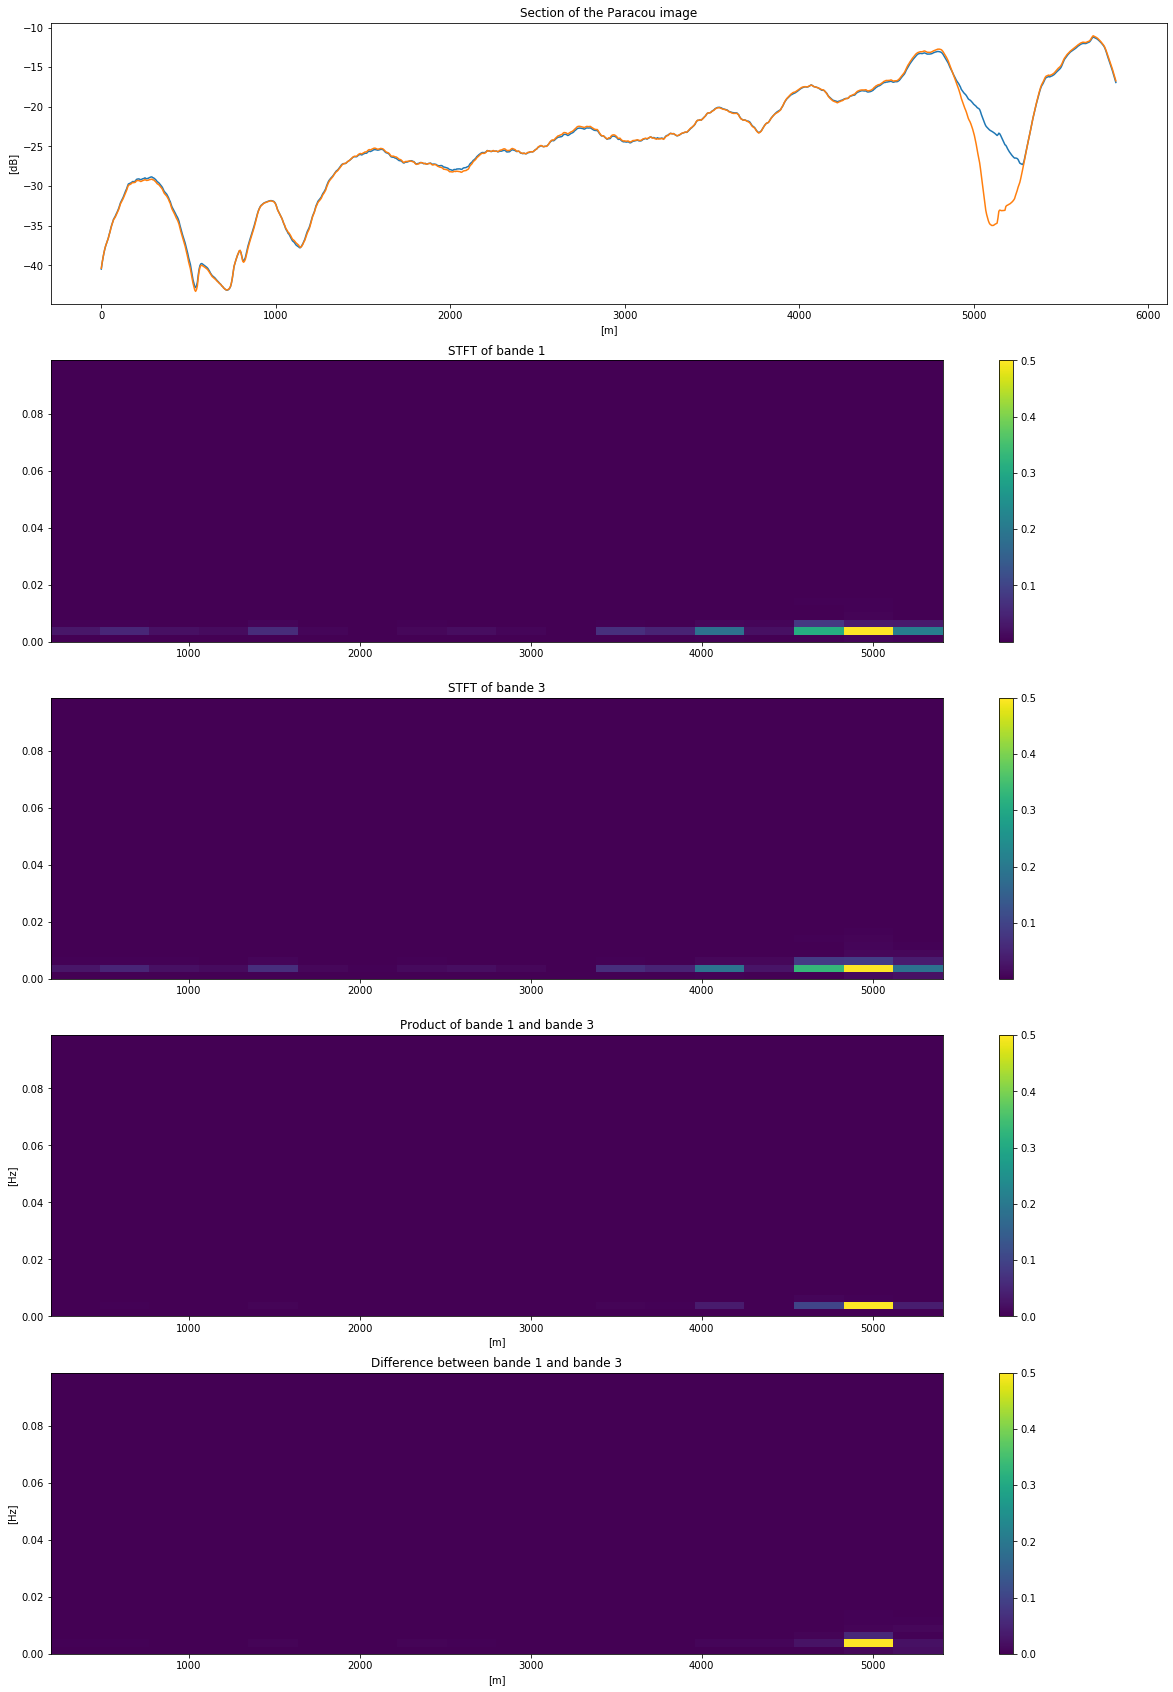

In [42]:
n = 50

ds_tar1 = ds_target1[:-30]
ds_tar3 = ds_target3[:-30]

#y = (len(ds_tar1))%n
#ds_tar1 = ds_target1[:-30-y]
#ds_tar3 = ds_target3[:-30-y]

#ds_tar1reso = np.zeros(int(len(ds_target1[:-30-y])/n))
#ds_tar3reso = np.zeros(int(len(ds_target1[:-30-y])/n))

v = 0
reso1 = 0
reso3 = 0

#for j in range(len(ds_tar1reso)):
#    for i in range(0,5):
#        reso1 += ds_tar1[i+v1
#        reso3 += ds_tar3[i+v]
#        v += 1
        
#    ds_tar1reso[j] = reso1/n
#    ds_tar3reso[j] = reso3/n
#    reso1 = 0
#    reso3 = 0
    
conv = np.ones(n)

ds_target1reso = np.convolve(conv, ds_tar1, mode ='same')/n
ds_target3reso = np.convolve(conv, ds_tar3, mode ='same')/n

nf = int(len(ds_target1[:-30])/(15))
win = ss.get_window(('tukey',0.3), nf)
win1 = ss.get_window(('hann'), nf)

f2, t2, Z2 = ss.spectrogram(ds_target1reso, fs,nperseg=nf, window=win,noverlap=nf/4., axis=-1, mode='psd')

f3, t3, Z3 = ss.spectrogram(ds_target3reso, fs,nperseg=nf, window=win,noverlap=nf/4., axis=-1, mode='psd')

plt.figure(figsize=(20,30))

plt.subplot(5,1,1)
plt.title("Section of the Paracou image")
plt.plot(x[:-30],np.log(ds_target1reso)*10,label="band 1")
plt.plot(x[:-30],np.log(ds_target3reso)*10, label = "band 3")
plt.xlabel("[m]")
plt.ylabel("[dB]")
plt.legend

plt.subplot(5,1,2)
plt.title('STFT of bande 1')
plt.pcolormesh(t2,f2,Z2,vmax = 0.5)
plt.colorbar()
plt.subplot(5,1,3)
plt.title('STFT of bande 3')
plt.pcolormesh(t3,f3,Z3,vmax=0.5)
plt.colorbar()
plt.subplot(5,1,4)
plt.pcolormesh(t2,f2,Z2*Z3,vmax=0.5)
plt.title('Product of bande 1 and bande 3')
plt.ylabel('[Hz]')
plt.xlabel('[m]')
plt.colorbar()
plt.subplot(5,1,5)
plt.pcolormesh(t2,f2,np.abs(Z2-Z3),vmax=0.5)
plt.title('Difference between bande 1 and bande 3')
plt.ylabel('[Hz]')
plt.xlabel('[m]')
plt.colorbar()




plt.show()


## Application on the whole image

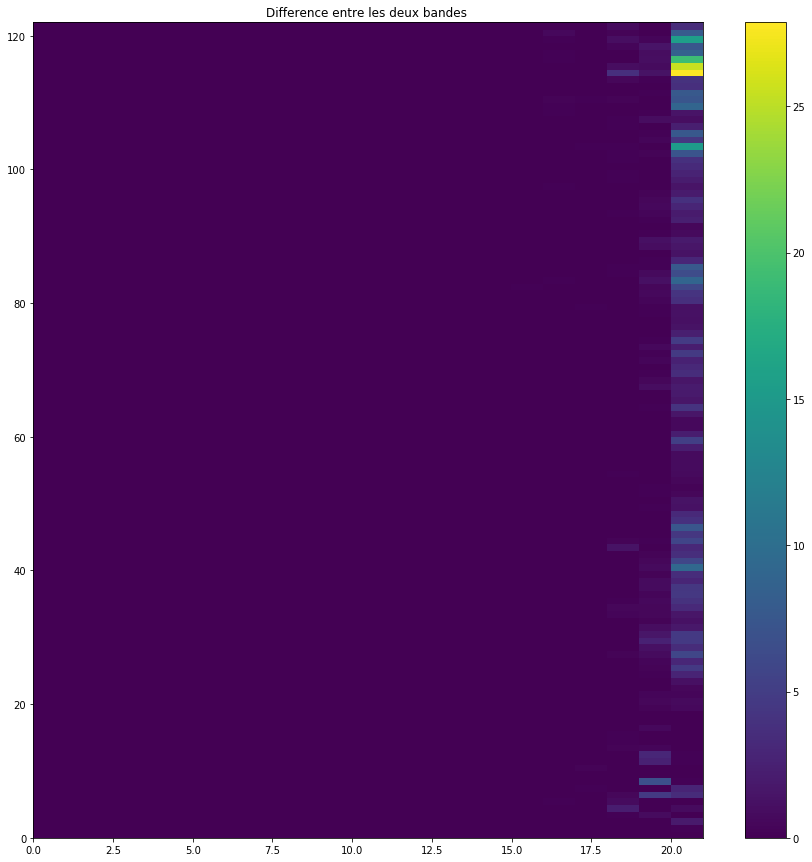

In [7]:
def mean_calc(im1,im2,ls,le):
    mean_im1=np.zeros(np.shape(im1[100,:]))
    mean_im2=np.copy(mean_im1)
    for i in range(ls,le):
        mean_im1 = im1[i,:] + mean_im1
        mean_im2 = im2[i,:] + mean_im2
    mean_im1 = mean_im1/(le-ls)
    mean_im2 = mean_im2/(le-ls)
    return mean_im1,mean_im2

def fix_lines(l1,l2):
    h = np.find(l1 = 0)

def image_partition(im1,im2,h=10):
    m,n = im1.shape
    l = m//h
    temp_im1 = np.zeros((l,n))
    temp_im2 = np.copy(temp_im1)
    for i in range(l):
        start = i*h
        end = (i+1)*h
        temp_im1[i,:],temp_im2[i,:] = mean_calc(im1,im2,start,end)
    return temp_im1, temp_im2


        
def calcul_spec(l1,l2,fs,nf = 2**6):
    ff, tt, ZZ2 = ss.spectrogram(l1,fs,nperseg=nf)
    ff, tt, ZZ1 = ss.spectrogram(l2,fs,nperseg=nf)
    
    return ff,tt,ZZ2*ZZ1



def im_spec(im1,im2,fs,nf=2**6,h=10):
    m1,m2 = image_partition(im1,im2,h)
    m,n = np.shape(m1)
    im_de_diff = np.zeros((m,n))
    for i in range(m):
        f,t,Z = calcul_spec(m1[i,:],m2[i,:],fs,nf)
        
        
    
mat1, mat2 = image_partition(ds_band1[:-30],ds_band3[:-30],h=15)
#plt.figure(figsize=(15,15))
#plt.imshow(np.log(mat1)*10)
#plt.colorbar()
#plt.show()

m,n = np.shape(mat1)

calcsp = np.zeros((m,21))                      #matrice avec les valeurs en dB pour chaque bande

for i in range(m):
    f,t,Z = calcul_spec(mat1[i,:],mat2[i,:],fs)
    X = np.zeros((1,21))                    
    for j in range(len(f)):
        X += Z[j,:]
    calcsp[i,:] = X/len(f)                     #recupération bande de freq sur les lignes

plt.figure(figsize=(15,15))  
plt.title("Difference entre les deux bandes ")
plt.pcolormesh(calcsp)
plt.colorbar()
plt.show()


#for i in range(15):
#    f,t,Z = calcul_spec(mat1[i,:],mat2[i,:],fs)
#    plt.title(m-i)
#    plt.pcolormesh(t,f,Z)
#    plt.colorbar()
#    plt.show()
